In [4]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import figure
import math

In [5]:
chelsea_imgs_list = glob.glob("./Data/image/Images/c*.jpg")
manu_imgs_list = glob.glob("./Data/image/Images/m*.jpg")

print(len(chelsea_imgs_list),len(manu_imgs_list))

64 58


In [6]:
#chelsea's label is 1 and manu's label is zero
chelsea_labels = np.ones(len(chelsea_imgs_list)).astype(np.int32)
manu_labels  = np.zeros(len(manu_imgs_list)).astype(np.int32)

images = list(np.hstack((chelsea_imgs_list, manu_imgs_list)))
labels = list(np.hstack((chelsea_labels, manu_labels)))


In [7]:
class Dataset:
    def __init__(self):
        self.images = list
        self.labels = list
        self.features_name = ["red_intensity",  "blue_intensity"]

        self.X =  np.array
        self.y = np.array

    def _image_to_array(self, im_list, labels):
        list_of_images = []
        for im in im_list:
            img = Image.open(im)
            list_of_images.append(np.array(img))

        self.images =list_of_images
        self.labels = labels

    def _calc_red_and_blue_intensity(self,img):
        return (np.mean(img[:,:,0]), np.mean(img[:,:,2]))

    
    def extract_feature(self, images, labels):
        self._image_to_array(im_list= images, labels= labels)
        features_value = []
        for img in self.images:
            features_value.append(list(self._calc_red_and_blue_intensity(img)))
                   
        self.X = np.array(features_value)
        self.y = np.array(self.labels)

        return self.X ,self.y

dataset = Dataset()
X, y = dataset.extract_feature(images, labels)

all_col = np.zeros((122,3))
all_col[:,:2] = X
all_col[:,2] = y
        
clean_dataset = pd.DataFrame(all_col, columns= ["R", "B", "label"])
    

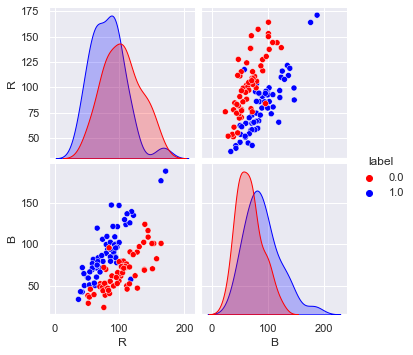

In [8]:
palette = {1: 'blue', 
    0 : 'red',
    }
g = sns.pairplot(clean_dataset, vars = clean_dataset.columns[0:2],
                 hue="label", palette=palette)

In [9]:
# plt.style.use('ggplot')
# plt.plot(clean_dataset[clean_dataset["label"]==0]["R"], clean_dataset[clean_dataset["label"]==0]["B"], 'ro', label='Manchester')
# plt.plot(clean_dataset[clean_dataset["label"]==1]["R"], clean_dataset[clean_dataset["label"]==1]["B"], 'bo', label='chelsea')
# plt.xlabel('red intensity')
# plt.ylabel('blue intensity')
# plt.legend()
# plt.show()

In [10]:
X = clean_dataset[["R", "B"]]
y = clean_dataset["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

In [11]:
class NaiveBayes:
    def __init__(self):

        self.features = list
        self.likelihoods = {}
        self.priors = {}
        self.X_train = np.array
        self.y_train = np.array
        self.class_list = list
        self.train_size = int 
        self.num_features  = int
        self.confusion_matrix = np.array

    def _calc_priors(self):

        self.class_list = np.unique(self.y_train)
        for _class in  self.class_list:
            self.priors[_class] = sum(self.y_train == _class)/self.train_size


    def _calc_likelihood(self):
        
        for feature in self.features:
            for _class in self.class_list:
                self.likelihoods[feature][_class]["mean"] = self.X_train[feature][self.y_train[self.y_train == _class].index.values.tolist()].mean()
                self.likelihoods[feature][_class]["variance"] = self.X_train[feature][self.y_train[self.y_train == _class].index.values.tolist()].var()


    def run_model(self , X, y): 
        
        self.X_train = X
        self.y_train = y
        self.features = list(X.columns)
        self.train_size = X.shape[0]
        self.num_features = X.shape[1]
        self.class_list = list(np.unique(y))
        self.confusion_matrix = np.zeros((len(self.class_list), len(self.class_list)))

        for feature in self.features: 

            self.likelihoods[feature] = {}

            for _class in self.class_list:
                self.likelihoods[feature].update({_class:{}})
                self.priors.update({_class:0})


        self._calc_priors()
        self._calc_likelihood()

    def  predict(self, X):
        
        X = np.array(X)
        results = []
        for row in X:
            prob_of_classes = {}

            for _class in  self.class_list:
                prior = self.priors[_class]
                evidence = 1
                likelihood = 1 
                
                for feature, feature_value in zip(self.features, row):
        
                    mean = self.likelihoods[feature][_class]["mean"]
                    var = self.likelihoods[feature][_class]["variance"]
                    likelihood *= (1/math.sqrt(2*math.pi*var)) * np.exp(-(feature_value - mean)**2 / (2*var))
                posterior_numerator = (likelihood * prior)/evidence
                prob_of_classes[_class] = posterior_numerator

            max_probability = max(prob_of_classes, key = lambda x : prob_of_classes[x])
            results.append(max_probability)

        return np.array(results)


    def make_confusing_matrix(self, y_true, y_pred):
        for i in range(len(self.class_list)):
            for j in range(len(self.class_list)):
                self.confusion_matrix[i,j] = np.sum((y_true == self.class_list[i])
                                                    &(y_pred == self.class_list[j]) )

        return self.confusion_matrix.astype(np.int32)

def calc_accuracy(y_true, y_pred):
	return round(float(sum(y_pred == y_true))/float(len(y_true)) * 100 ,2)
    

def calc_precision_recall(confusion_matrix):
    tp = confusion_matrix[0,0]
    fn = confusion_matrix[0,1]
    fp = confusion_matrix[1,0]
    tn = confusion_matrix[1,1]

    precision = round(float(tp/(tp+fp))*100, 2)
    recall = round(float(tp/(tp+fn))*100,2)

    return precision, recall


In [12]:
clf_model = NaiveBayes()
clf_model.run_model(X_train, y_train)
	#print(X_train, y_train)
y_pred = clf_model.predict(X_test)
test_accuracy = calc_accuracy(y_test, y_pred)
print("Test Accuracy: {}".format(test_accuracy))

Test Accuracy: 90.32


Text(59.400000000000006, 0.5, 'predicted label')

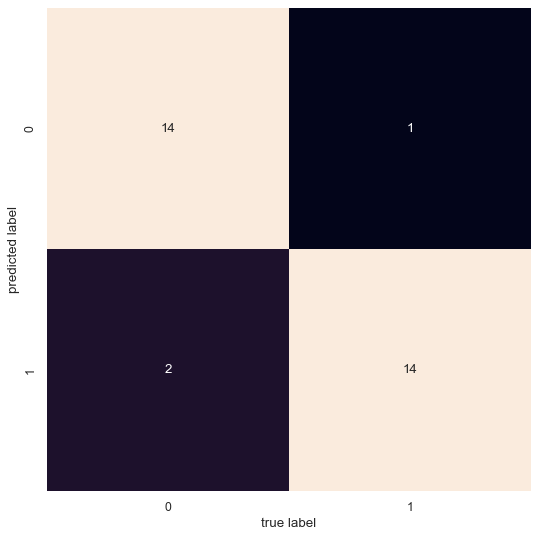

In [13]:
figure(figsize=(8,8), dpi=80)
confusion_mtx = clf_model.make_confusing_matrix(y_test, y_pred)

sns.heatmap(confusion_mtx.T,  square=True, 
        annot= True ,  fmt ="d", cbar= False,
         #xticklabels=iris.target_names, yticklabels=iris.target_names
          )
plt.xlabel('true label')
plt.ylabel('predicted label')

In [14]:
precision, recall = calc_precision_recall(confusion_mtx)
print("precision : ", precision,"\n", "recall : ", recall)

precision :  93.33 
 recall :  87.5


In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names= np.array(["0","1"])))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90        16
           1       0.88      0.93      0.90        15

    accuracy                           0.90        31
   macro avg       0.90      0.90      0.90        31
weighted avg       0.91      0.90      0.90        31

